In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import postprocessing
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 13

/home/dbeckers/.conda/envs/postprocessing_v2/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dbeckers/.config/yt/ytrc is deprecated in favor of /home/dbeckers/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [4]:
yt.set_log_level(50)

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
def init_animation():
    for line in lines:
        line.set_data([],[])
    return lines

In [7]:
class OneDimScalarDistribution:
    def __init__(self, name, u, x0, amplitude, width, wavenumber):
        self.name = name
        self.u = u
        self.x0 = x0
        self.amplitude = amplitude
        self.width = width
        self.wavenumber = wavenumber

In [8]:
class GaussianPulse(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 6 * self.width):
            return self.amplitude * math.exp( - ((x - convected_distance) - self.x0) ** 2 / (2 * self.width ** 2))
        else:
            return 0.0

In [9]:
class SquarePulse(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 0.5 * self.width):
            return self.amplitude
        else:
            return 0.0

In [10]:
class GaussianWavePacket(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 6 * self.width):
            return math.cos(self.wavenumber * (x-convected_distance)) * self.amplitude * math.exp( - ((x-convected_distance) - self.x0) ** 2 / (2 * self.width ** 2))
        else:
            return 0.0

In [11]:
x_exact = np.linspace(0, 1, num=2000)
lw_exact = 0.5
ls_exact = 'dashed'

In [12]:
root_dir = '/scratch/dbeckers/scalar_advection'

## Gaussian pulse - uniform grid

In [13]:
gaussianpulse = GaussianPulse("gaussianpulse_CFL_0.45",1.0,0.25,1.0,0.01,0)
case_dir = gaussianpulse.name+"/uniform"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']
grid_sizes = [128]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

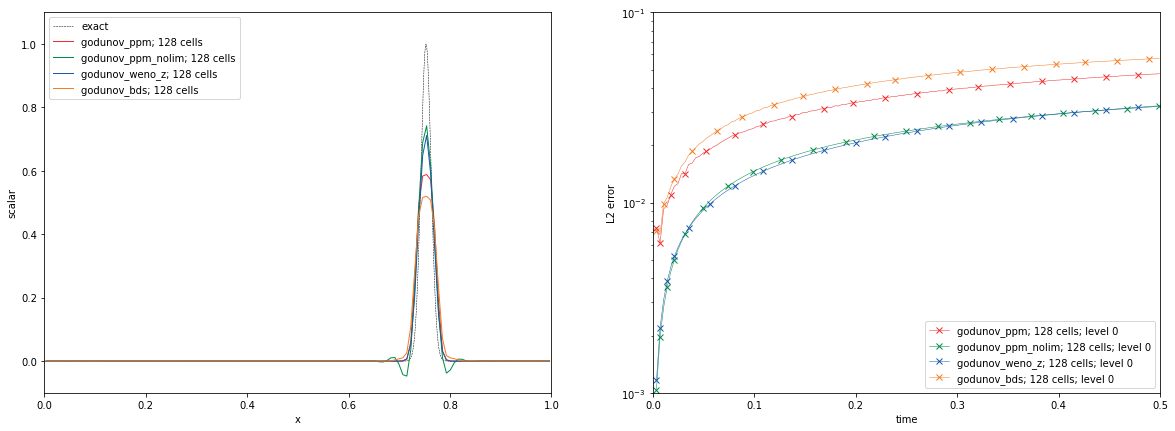

In [14]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].plot(x_exact,[gaussianpulse.exact_solution(x_i,0.502734) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(axs[0],root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,colormethods=True,ylim=[-0.1,1.1],variable='temperature')
postprocessing.batch_plot_error(axs[1],'error.log',root_dir,case_dir,methods,grid_sizes,0.5,withglobal=False,maxlevel=0,ylogscale=True,linewidth=0.5,ylim=[1e-3,1e-1])
fig.savefig(f'{gaussianpulse.name}_uniform.png',dpi=300)

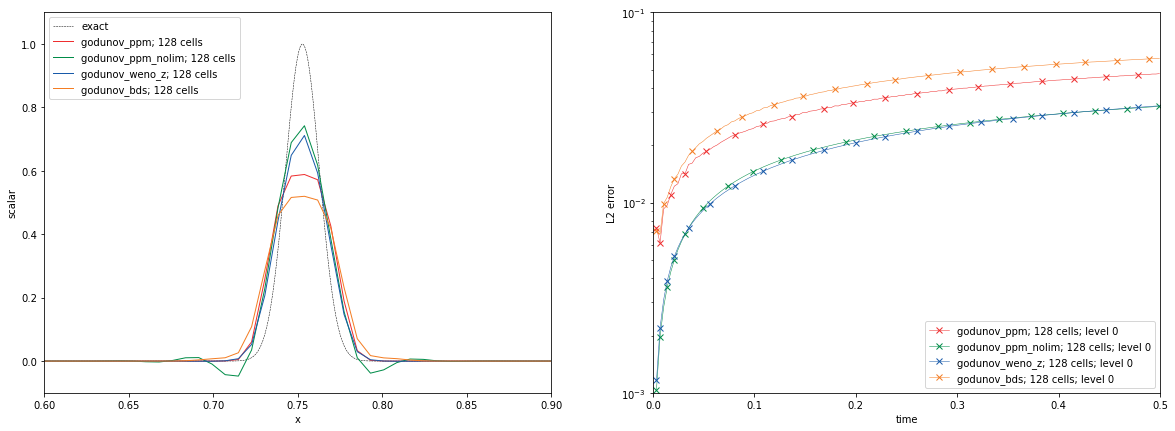

In [15]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].plot(x_exact,[gaussianpulse.exact_solution(x_i,0.502734) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(axs[0],root_dir,case_dir,methods,grid_sizes,-1,(0.6,0,0),(0.9,0,0),use_ray_coord=False,colormethods=True,ylim=[-0.1,1.1],variable='temperature')
postprocessing.batch_plot_error(axs[1],'error.log',root_dir,case_dir,methods,grid_sizes,0.5,withglobal=False,maxlevel=0,ylogscale=True,linewidth=0.5,ylim=[1e-3,1e-1])
axs[0].legend(loc='upper left')
fig.savefig(f'{gaussianpulse.name}_uniform_centered.png',dpi=300)

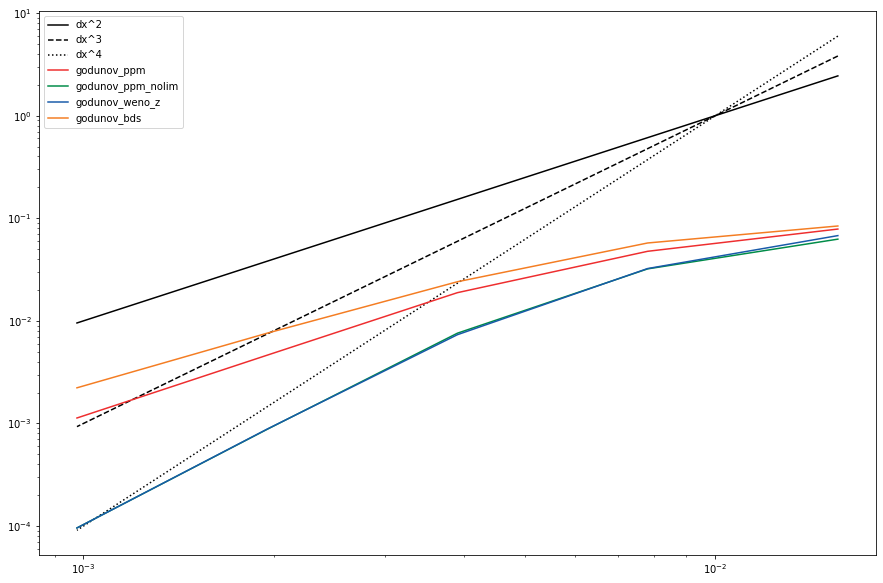

In [16]:
grid_sizes = [64,128,256,512,1024]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=False)
fig,ax = plt.subplots(figsize=[15,10])
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'{gaussianpulse.name}_uniform_convergence.png',dpi=300)

## Gaussian wave packet - uniform grid

In [17]:
gaussianwavepacket = GaussianWavePacket("gaussianwavepacket_CFL_0.45",1.0,0.25,1.0,0.0251646060,226.1946710304)
case_dir = gaussianwavepacket.name+"/uniform"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','mol_central']
grid_sizes = [1024]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

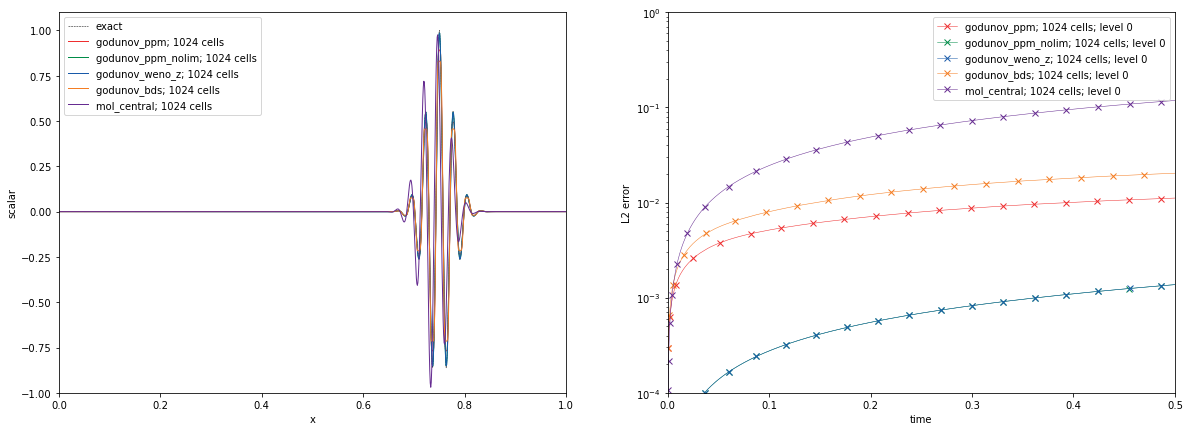

In [18]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
axs[0].legend(loc='lower right')
postprocessing.batch_plot_ray(axs[0],root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,colormethods=True,ylim=[-1.0,1.1])
postprocessing.batch_plot_error(axs[1],'error.log',root_dir,case_dir,methods,grid_sizes,0.5,withglobal=False,maxlevel=0,ylogscale=True,linewidth=0.5,ylim=[1e-4,1e-0])
fig.savefig(f'{gaussianwavepacket.name}_uniform.png',dpi=300)

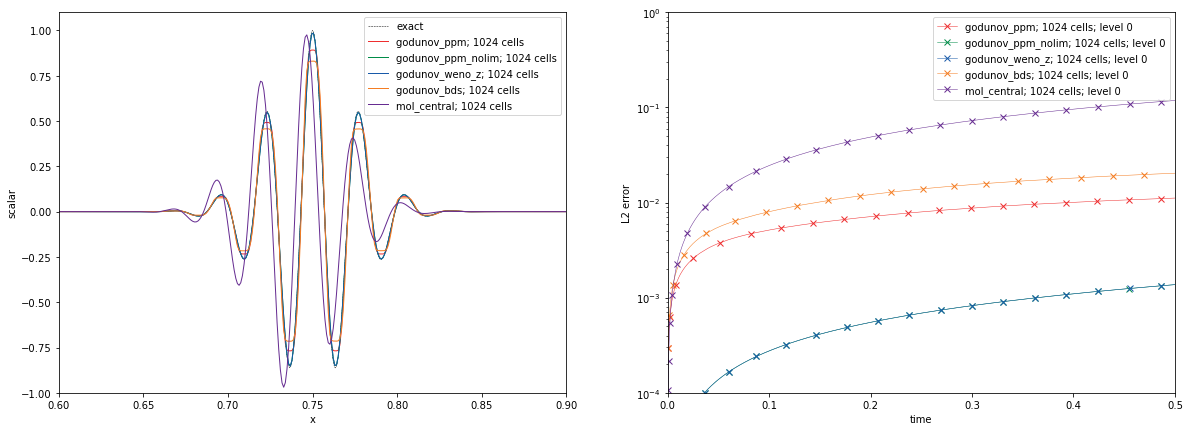

In [19]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
axs[0].legend(loc='lower right')
postprocessing.batch_plot_ray(axs[0],root_dir,case_dir,methods,grid_sizes,-1,(0.6,0,0),(0.9,0,0),use_ray_coord=False,colormethods=True,ylim=[-1.0,1.1])
postprocessing.batch_plot_error(axs[1],'error.log',root_dir,case_dir,methods,grid_sizes,0.5,withglobal=False,maxlevel=0,ylogscale=True,linewidth=0.5,ylim=[1e-4,1e-0])
fig.savefig(f'{gaussianwavepacket.name}_uniform_centered.png',dpi=300)

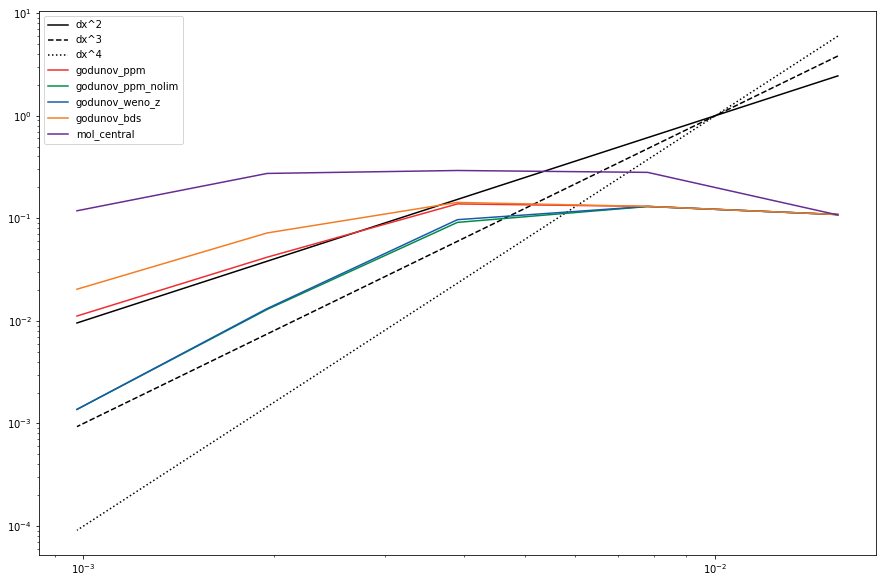

In [20]:
grid_sizes = [64,128,256,512,1024]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=False)
fig_convergence,ax_convergence = plt.subplots(figsize=[15,10])
ax_convergence.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax_convergence.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax_convergence.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax_convergence.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax_convergence.set_xscale('log')
ax_convergence.set_yscale('log')
ax_convergence.legend()
fig_convergence.savefig(f'{gaussianwavepacket.name}_uniform_convergence.png',dpi=300)

## Gaussian wave packet - fine-to-coarse grid

In [21]:
gaussianwavepacket = GaussianWavePacket("gaussianwavepacket_CFL_0.45",1.0,0.25,1.0,0.0251646060,226.1946710304)
case_dir = gaussianwavepacket.name+"/fine_to_coarse"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','mol_central']
grid_sizes = [512]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

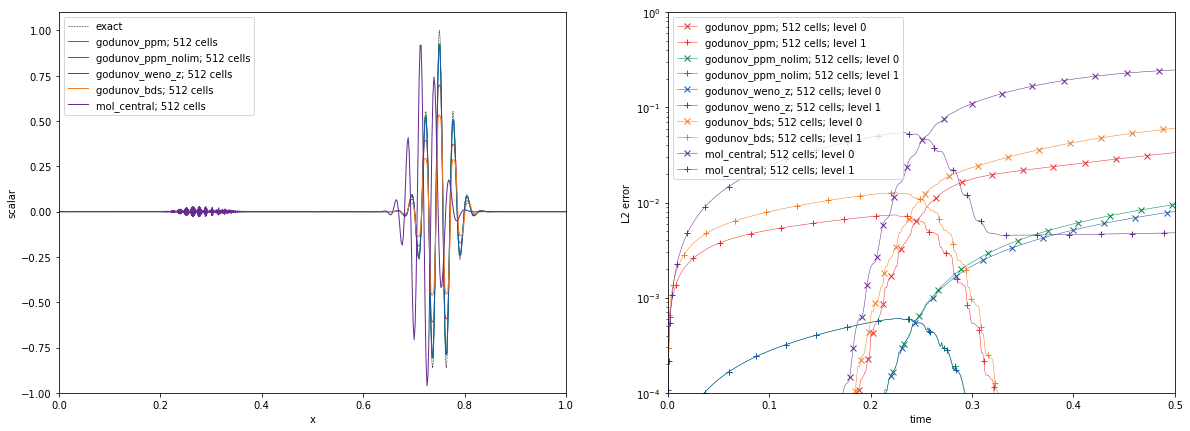

In [22]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(axs[0],root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,colormethods=True,ylim=[-1.0,1.1])
postprocessing.batch_plot_error(axs[1],'error.log',root_dir,case_dir,methods,grid_sizes,0.5,withglobal=False,maxlevel=1,ylogscale=True,linewidth=0.5,ylim=[1e-4,1e-0])
fig.savefig(f'{gaussianwavepacket.name}_fine_to_coarse.png',dpi=300)

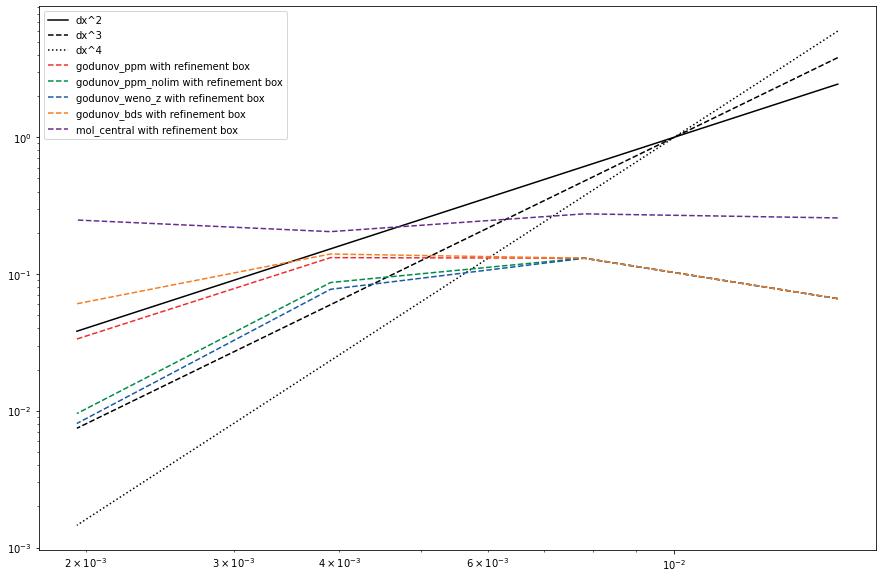

In [23]:
grid_sizes = [64,128,256,512]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
fig,ax = plt.subplots(figsize=[15,10])
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=True)
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_global'].values[-1] for df_error_grid in error_list[i_method]],label=f'{methods[i_method]} with refinement box',linestyle='dashed',color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'{gaussianwavepacket.name}_fine_to_coarse_convergence.png',dpi=300)

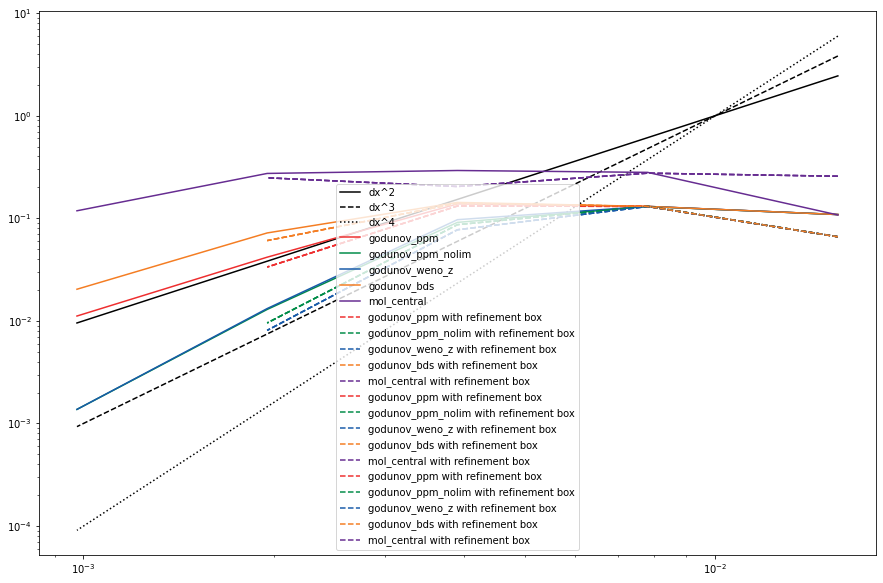

In [26]:
grid_sizes = [64,128,256,512]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=True)
for i_method in range(len(methods)):
    ax_convergence.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_global'].values[-1] for df_error_grid in error_list[i_method]],label=f'{methods[i_method]} with refinement box',linestyle='dashed',color=postprocessing.color_list[i_method])
ax_convergence.legend()
fig_convergence.savefig(f'{gaussianwavepacket.name}_combo_convergence.png',dpi=300)
fig_convergence

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
fig,axs = plt.subplots(1,2,figsize=(20,7))
lines1 = postprocessing.setup_batch_line_plot(axs[0],methods,grid_sizes,[0,1],[-0.2,1.4],'x','scalar',errorlines=False)
lines2 = postprocessing.setup_batch_line_plot(axs[1],methods,grid_sizes,[0,0.5],[1e-6,1e-1],'t','L2 error',errorlines=True,maxlevel=maxlevel,withglobal=withglobal,ylogscale=True)
lines = lines1 + lines2

def animate(i):
    ds_list = postprocessing.batch_load_plt(root_dir,case_dir,methods,grid_sizes,i)
    error_df_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=withglobal)

    times = postprocessing.batch_set_ray_data(lines[:len(lines1)],ds_list,[0,0,0],[1,0,0],return_times=True)    
    postprocessing.batch_set_error_data(lines[len(lines1):],error_df_list,times[0],maxlevel=maxlevel,withglobal=withglobal)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=minpltcount, interval=100, blit=True)

In [184]:
gaussianpulse = GaussianPulse("gaussianpulse_CFL_0.45",1.0,0.25,1.0,0.01,0)
case_dir = gaussianpulse.name+"/fine_to_coarse"
methods = ['godunov_ppm']
grid_sizes = [256]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

In [206]:
case_dir_home = "gaussianpulse/fine_to_coarse"
root_dir_home = "home/dbeckers/tests/scalar_advection"


In [207]:
f'{root_dir_home}/{methods[0]}/{case_dir_home}/nx_64'

'home/dbeckers/tests/scalar_advection/godunov_ppm/gaussianpulse/fine_to_coarse/nx_64'

In [213]:
postprocessing.plt_count('/home/dbeckers/tests/scalar_advection/godunov_ppm/gaussianpulse/fine_to_coarse/nx_64')

19

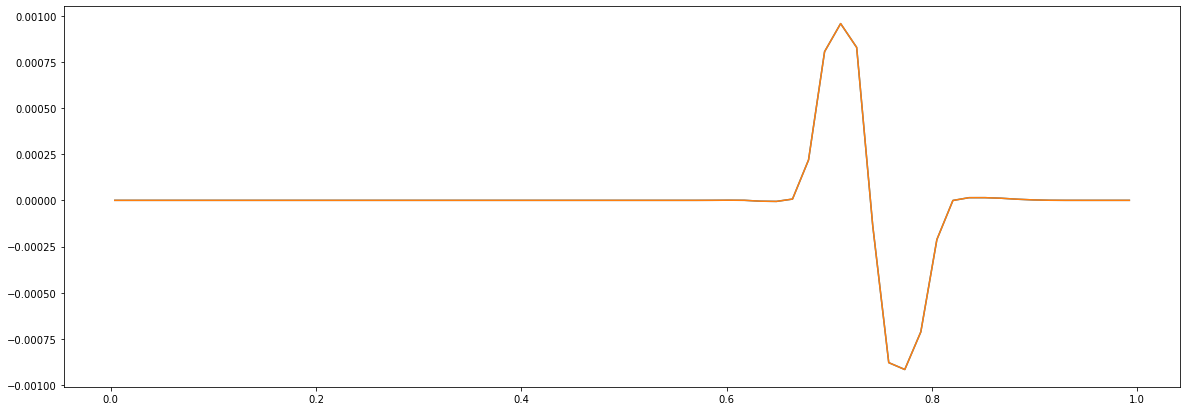

In [214]:
fig,ax = plt.subplots(figsize=(20,7))
ds_scratch = postprocessing.load_plt(f'{root_dir}/{methods[0]}/{case_dir}/nx_64',-1)
ds_home = postprocessing.load_plt('/home/dbeckers/tests/scalar_advection/godunov_ppm/gaussianpulse/fine_to_coarse/nx_64',-1)
df_scratch = postprocessing.sample_ray(ds,(0,0,0),(1,0,0))
df_home = postprocessing.sample_ray(ds,(0,0,0),(1,0,0))

ax.plot(df_scratch['x'],df_scratch['temperature'])
ax.plot(df_home['x'],df_home['temperature'])

In [192]:
f'{root_dir}/{methods[0]}/{case_dir}'

'/scratch/dbeckers/scalar_advection/godunov_ppm/gaussianwavepacket_CFL_0.45/fine_to_coarse'

In [23]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
fig,axs = plt.subplots(1,2,figsize=(20,7))
lines1 = postprocessing.setup_batch_line_plot(axs[0],methods,grid_sizes,[0,1],[-0.2,1.4],'x','scalar',errorlines=False)
lines2 = postprocessing.setup_batch_line_plot(axs[1],methods,grid_sizes,[0,0.5],[1e-6,1e-1],'t','L2 error',errorlines=True,maxlevel=maxlevel,withglobal=withglobal,ylogscale=True)
lines = lines1 + lines2

def animate(i):
    ds_list = postprocessing.batch_load_plt(root_dir,case_dir,methods,grid_sizes,i)
    error_df_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=withglobal)

    times = postprocessing.batch_set_ray_data(lines[:len(lines1)],ds_list,[0,0,0],[1,0,0],return_times=True)    
    postprocessing.batch_set_error_data(lines[len(lines1):],error_df_list,times[0],maxlevel=maxlevel,withglobal=withglobal)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=minpltcount, interval=100, blit=True)

In [24]:
anim

KeyboardInterrupt: 

## Gaussian pulse - fine-to-coarse grid

In [12]:
case_dir = gaussianpulse.name+"/fine_to_coarse"
methods = ['godunov_ppm']
grid_sizes = [128]
maxlevel = 1
withglobal = True
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

In [13]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
fig,axs = plt.subplots(1,2,figsize=(20,7))
lines1 = postprocessing.setup_batch_line_plot(axs[0],methods,grid_sizes,[0,1],[-0.2,1.4],'x','scalar',errorlines=False)
lines2 = postprocessing.setup_batch_line_plot(axs[1],methods,grid_sizes,[0,0.5],[1e-6,1e-1],'t','L2 error',errorlines=True,maxlevel=maxlevel,withglobal=withglobal,ylogscale=True)
lines = lines1 + lines2

def animate(i):
    ds_list = postprocessing.batch_load_plt(root_dir,case_dir,methods,grid_sizes,i)
    error_df_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,withglobal=withglobal)

    times = postprocessing.batch_set_ray_data(lines[:len(lines1)],ds_list,[0,0,0],[1,0,0],return_times=True)    
    postprocessing.batch_set_error_data(lines[len(lines1):],error_df_list,times[0],maxlevel=maxlevel,withglobal=withglobal)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=minpltcount, interval=100, blit=True)

In [14]:
anim

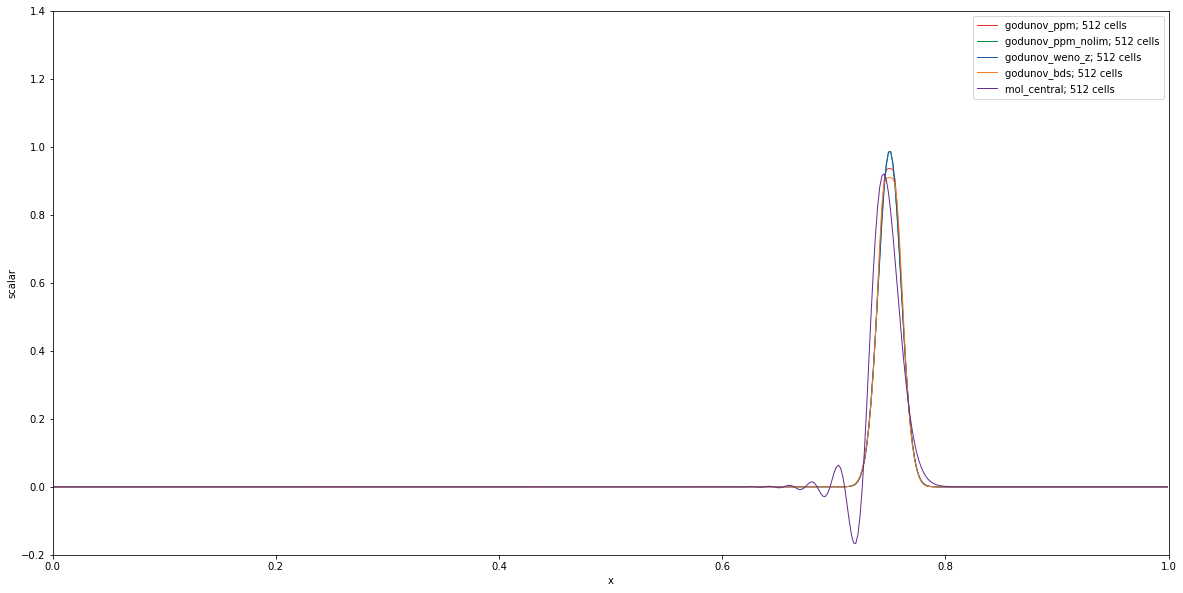

In [21]:
fig,ax = plt.subplots(figsize=(20,10))
postprocessing.batch_plot_ray(ax,root_dir,gaussianpulse.name+"/uniform",methods,[512],-1,(0,0,0),(1,0,0),use_ray_coord=False,colormethods=True)

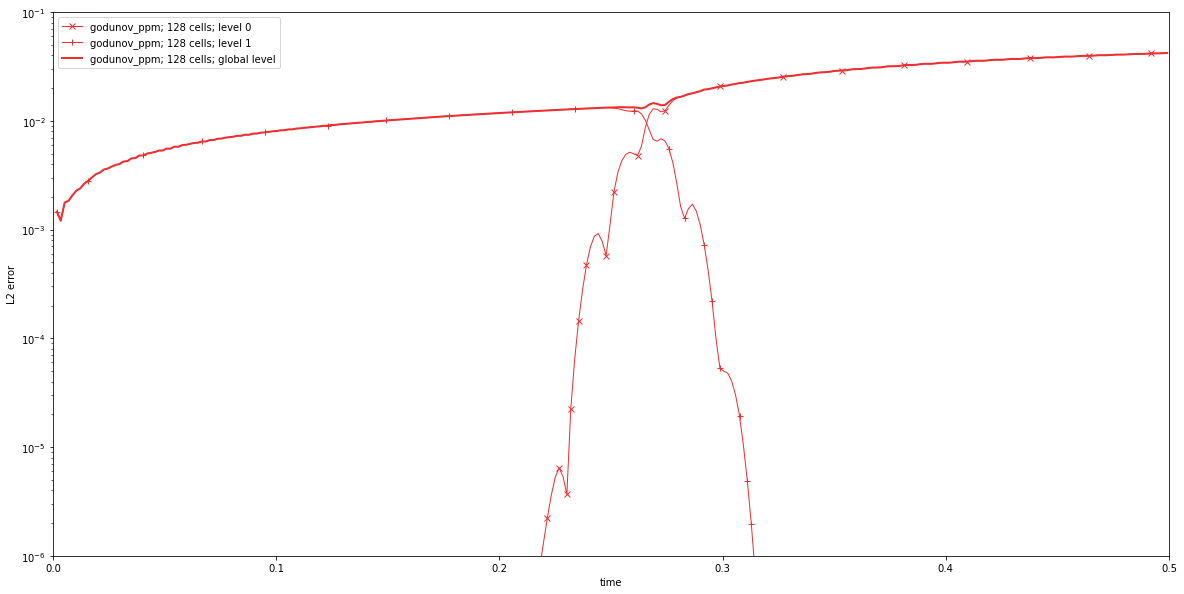

In [132]:
fig,ax = plt.subplots(figsize=(20,10))
postprocessing.batch_plot_error(ax,'error.log',root_dir,gaussianpulse.name+"/fine_to_coarse",['godunov_ppm'],[128],0.5,withglobal=True,maxlevel=1,ylogscale=True)

In [80]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1,printdir=False):
    t_list = []
    x_list = []
    s_list = []
    i_method = -1
    for method in methods:
        i_method += 1
        
        t_list_method = []
        x_list_method = []
        s_list_method = []

        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(rootdir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                if printdir:
                    print(f'{case_dir}')
                
                ds = yt.load(plt_files[idx])

                ray = ds.ortho_ray(0, (0, 0))
                srt = np.argsort(ray[("gas","x")])
                df = pd.DataFrame({f: np.array(ray[("gas",f)][srt]) for f in ["x","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                t_list_method.append(t)
                x_list_method.append(df["x"].values)
                s_list_method.append(df["temperature"].values)
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t:2.4f}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t:2.4f}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    
        t_list.append(t_list_method)
        x_list.append(x_list_method)
        s_list.append(s_list_method)
    
    return t_list, x_list, s_list
            

In [81]:
def postprocess_error(case,t,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1):
    t_list = []
    error_list = []
    i_method = -1
    for method in methods:
        i_method += 1
        errors_list_method = []
        t_list_method = []
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(rootdir, method, case, grid_type, f'nx_{grid_size}')
                


                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-1
                    time = [float(line.split()[0]) for line in lines]
                    idx = time.index(min(time, key=lambda x:abs(x-t)))+1
                    
                    errors_grid_size = []

                    for level in reversed(range(error_levels)):
                        errors_grid_size.append([float(line.split()[level+1]) for line in lines][:idx])
                    errors_list_method.append(errors_grid_size)
                    t_list_method.append(time[:idx])

                    if plotting:
                        for level in range(error_levels):
                            if line_configuration == 1:
                                ax.plot(time[:idx], errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                            else:
                                ax.plot(time[:idx], errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
        
            
        t_list.append(t_list_method)
        error_list.append(errors_list_method)
        
    return t_list, error_list
            

In [82]:
def postprocess_convergence(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration=1):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(rootdir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
        if line_configuration == 1:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black')
        else:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color=line_colors[i_method])

In [83]:
def setup_animation_fig(methods, grid_sizes, grid_type, linestyle_list, color_list, figsize=(10,12), with_error=False, max_level=0, with_exact_sol=False, scalar_ylim=[-0.1,1.3], error_ylim=[1e-7,1e-4],line_configuration=1):
    """
    Set up a figure with line plots for animation purposes.

    """
    
    if with_error:
        fig, axs = plt.subplots(1,2,figsize=figsize)
        ax_scalar = axs[0]
    else:
        fig, ax = plt.subplots(1,figsize=figsize)
        ax_scalar = ax
    
    lines = []
    
    if with_exact_sol:
        line = axs[0].plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
        lines.append(line)
    
    for i_method in range(len(methods)):
        for i_grid_size in range(len(grid_sizes)):
            if line_configuration == 1:
                line = axs[0].plot([],[],color=color_list[i_method],linewidth=1.0,linestyle=linestyle_list[i_grid_size],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]
            else:
                line = axs[0].plot([],[],color=color_list[i_grid_size],linewidth=1.0,linestyle=linestyle_list[i_method],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]
            lines.append(line)
        
    ax_scalar.legend(loc='upper left')
    ax_scalar.set_xlabel('x')
    ax_scalar.set_ylabel('scalar')
    ax_scalar.set_xlim([0,1])
    ax_scalar.set_ylim(scalar_ylim)
    
    if with_error:
        for i_method in range(len(methods)):
            for i_grid_size in range(len(grid_sizes)):
                # First error line with label
                if line_configuration == 1:
                    line = axs[1].plot([],[],color=color_list[i_method],linewidth=1.0,linestyle=linestyle_list[i_grid_size],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]
                else:
                    line = axs[1].plot([],[],color=color_list[i_grid_size],linewidth=1.0,linestyle=linestyle_list[i_method],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]                
                lines.append(line)
                # Next error lines without label
                for level in range(max_level):
                    if line_configuration == 1:
                        line = axs[1].plot([],[],color=color_list[i_method],linewidth=1.0,linestyle=linestyle_list[i_grid_size])[0]
                    else:
                        line = axs[1].plot([],[],color=color_list[i_grid_size],linewidth=1.0,linestyle=linestyle_list[i_method])[0]
                    lines.append(line)
        
        axs[1].legend(loc='upper left')
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('L2_error')
        axs[1].set_xlim([0,0.5])
        axs[1].set_ylim(error_ylim)
        axs[1].set_yscale('log')
        
    return fig, lines

In [84]:
def set_lines_data(lines, i, scalardist, methods, grid_sizes, grid_type, with_error=False, max_level=0, with_exact_sol=False):
    """
    Sets the data of each line in `lines` to the scalar distribution for each method for the `i`-th plot file and similarly for the error if `with_error` is `True`. The error time is taken from the `i`-th plotfile of the first grid size and first method.

    """
    t_list, x_list, s_list = postprocess_dist(scalardist.name,i,root_dir,methods,[grid_type],grid_sizes,None,None,None,None,plotting=False)
    t_list_error, error_list = postprocess_error(scalardist.name,t_list[0][0],root_dir,methods,[grid_type],grid_sizes,None,None,None,None,plotting=False)
    
    if with_exact_sol:
        i_line = 1
    else:
        i_line = 0

    for i_method in range(len(methods)):
        for i_grid_size in range(len(grid_sizes)):
            lines[i_line].set_data(x_list[i_method][i_grid_size],s_list[i_method][i_grid_size])
            i_line += 1
            
    if with_exact_sol:
        scalar_exact = [scalardist.exact_solution(x_i,t_list[0][0]) for x_i in x_exact]
        lines[0].set_data(x_exact,scalar_exact)
                
    if with_error:
        for i_method in range(len(methods)):
            for i_grid_size in range(len(grid_sizes)):
                for level in range(max_level+1):
                    lines[i_line].set_data(t_list_error[i_method][i_grid_size],error_list[i_method][i_grid_size][level])
                    i_line += 1
        
    return lines

In [85]:
def init_animation():
    for line in lines:
        line.set_data([],[])
    return lines

In [86]:
def animate(i):
    set_lines_data(lines, i, scalardist, methods, grid_size, grid_type, with_error=True, max_level=1, with_exact_sol=False)

In [87]:
root_dir = '/home/dbeckers/tests/scalar_advection'

In [88]:
x_exact = np.linspace(0, 1, num=1000)
lw_exact = 0.5
ls_exact = 'dashed'

# Gaussian pulse; Uniform grid

In [91]:
gaussianpulse = GaussianPulse("gaussianpulse",1.0,0.25,1.0,0.01,0)

In [92]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_weno_z','godunov_ppm_nolim','mol_central']; grid_sizes = [128]; grid_type = 'uniform'

fig, lines = setup_animation_fig(methods, grid_sizes, grid_type, ['solid'], postprocessing.color_list, figsize=(20,7), with_error=True, max_level=0, with_exact_sol=True, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0])

def animate(i):
    set_lines_data(lines, i, gaussianpulse, methods, grid_sizes, grid_type, with_error=True, max_level=0, with_exact_sol=True)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=19, interval=100, blit=True)

In [93]:
anim

NameError: name 'natural_sort' is not defined

# Gaussian pulse; Fine-to-coarse grid

In [ ]:
gaussianpulse = GaussianPulse("gaussianpulse",1.0,0.25,1.0,0.01,0)

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_weno_z','godunov_ppm_nolim','mol_central']; grid_sizes = [128]; grid_type = 'fine_to_coarse'

fig, lines = setup_animation_fig(methods, grid_sizes, grid_type, ['solid'], color_list, figsize=(20,7), with_error=True, max_level=1, with_exact_sol=True, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0])

def animate(i):
    set_lines_data(lines, i, gaussianpulse, methods, grid_sizes, grid_type, with_error=True, max_level=1, with_exact_sol=True)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=19, interval=100, blit=True)

In [ ]:
anim

### Weird behavior for weno-z?

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_weno_z']; grid_sizes = [64,128,256]; grid_type = 'fine_to_coarse'

fig, lines = setup_animation_fig(methods, grid_sizes, grid_type, ['solid'], color_list, figsize=(20,7), with_error=True, max_level=1, with_exact_sol=True, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], line_configuration=2)

def animate(i):
    set_lines_data(lines, i, gaussianpulse, methods, grid_sizes, grid_type, with_error=True, max_level=1, with_exact_sol=True)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=19, interval=100, blit=True)

In [ ]:
anim

# Square pulse

In [ ]:
squarepulse = SquarePulse("squarepulse",1.0,0.25,1.0,0.05,0)

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_weno_z','godunov_ppm_nolim']; grid_sizes = [128]; grid_type = 'fine_to_coarse'

fig, lines = setup_animation_fig(methods, grid_sizes, grid_type, ['solid'], color_list, figsize=(20,7), with_error=True, max_level=1, with_exact_sol=True, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0])

def animate(i):
    set_lines_data(lines, i, squarepulse, methods, grid_sizes, grid_type, with_error=True, max_level=1, with_exact_sol=True)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=19, interval=100, blit=True)

In [ ]:
anim

# Gaussian wave packet

In [ ]:
gaussianwavepacket = GaussianWavePacket("gaussianwavepacket",1.0,0.25,1.0,0.0251646060,226.1946710304)

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_weno_z','godunov_ppm_nolim','mol_central']; grid_sizes = [256]; grid_type = 'fine_to_coarse'

fig, lines = setup_animation_fig(methods, grid_sizes, grid_type, ['solid'], color_list, figsize=(20,7), with_error=True, max_level=1, with_exact_sol=True, scalar_ylim=[-1.1,1.3], error_ylim=[1e-6,1e0])

def animate(i):
    set_lines_data(lines, i, gaussianwavepacket, methods, grid_sizes, grid_type, with_error=True, max_level=1, with_exact_sol=True)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=19, interval=100, blit=True)

In [ ]:
anim

In [ ]:
fig, ax = plt.subplots(2,figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_weno_z; nx = 256; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')



In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

scalar_exact = [function(x_i,center,amplitude,width,wavenumber,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist(gaussianpulse.name,-1,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z'],['fine_to_coarse'],[128],
                 ax,linestyle_list,color_list,[1.0],True,2,False)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-0.1,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 2

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_weno_z; nx = 256; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist(f'{function.__name__}',i,root_dir,['godunov_weno_z'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,[1.0],False,2,False)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,wavenumber,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)

In [ ]:
anim

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error(function.__name__,0.5,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','mol_central'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.legend(loc='upper left')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-7,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

# Square pulse - fine-to-coarse

In [ ]:
center = 0.25
amplitude = 1.0
width = 0.05
wavenumber = 0
t_final = 0.5
function = squarepulse

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,wavenumber,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist(function.__name__,-1,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','mol_central'],['uniform'],[256],
                 ax,linestyle_list,color_list,[1.0],True,2,False)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-0.1,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 19

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm_nolim; nx = 256; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist(f'{function.__name__}',i,root_dir,['godunov_ppm_nolim'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,[1.0],False,2,False)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,wavenumber,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)

In [ ]:
anim

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error(function.__name__,0.5,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.legend(loc='upper left')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-4,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

# Gaussian wave packet - fine-to-coarse

In [ ]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
wavenumber = 226.1946710304
t_final = 0.5
function = gaussianwavepacket

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,wavenumber,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist(function.__name__,-1,root_dir,['mol_central'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,[1.0],True,2,False)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 19

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm_nolim; nx = 256; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist(f'{function.__name__}',i,root_dir,['godunov_ppm_nolim'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,[1.0],False,2,False)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,wavenumber,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)

In [ ]:
anim

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error(function.__name__,0.5,root_dir,['godunov_ppm','godunov_ppm_nolim','godunov_weno_z'],['fine_to_coarse'],[256],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.legend(loc='upper left')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')